In [1]:
import numpy as np
import matplotlib.pyplot as plt

from confusion import ConfusionMatrix
from loader import echo_study
from util import resolve_compensation_value, mean_of_matrices

('null', 'no-version')
('5de62d28d82800000b7f2913', 'missing-data')
('5f1f37e9c19b6d0ff7bd3969', 'missing-data')
('5f0af202ec6afa02e8db0daf', 'missing-data')
('5f8d41fb88b469000bfd0264', 'missing-data')
('5fc44d83862e3e79b02e0438', 'missing-data')
('5feb726715b59bbd3c904409', 'marked-invalid')
('5e8f67f9cc3d6c24f4b646c9', 'missing-data')
('5e8bb1446a80c60905c99673', 'missing-data')
('5bc2e0ec4f3bfd00012e97b5', 'missing-data')
('5ee8afa133ad1a0a28460c03', 'missing-data')
('5f2f46b2c1cba4190424f343', 'missing-data')
('5f1f37e9c19b6d0ff7bd3969', 'missing-data')
('5f2f46b2c1cba4190424f343', 'missing-data')
('5d1751e2ede7260018ea70fb', 'missing-data')
('5febda8badaa09d0c281c8c4', 'marked-invalid')
('5f9e580a30a3e740cc778b39', 'missing-data')
('5febda8badaa09d0c281c8c4', 'marked-invalid')
('5f9e580a30a3e740cc778b39', 'missing-data')
('5f62744d84c6fb19a14d688c', 'missing-data')
('5f9f0149e129f5503323c6a5', 'missing-data')
('5f9dc7cf9a848c33d0864aa7', 'missing-data')
('5febda8badaa09d0c281c8c4

In [2]:
from functools import reduce
from util import resolve_compensation_value, mean_of_matrices

def plot_confusion(conditions, title, label_fields):
    fig, axes = plt.subplots(nrows=1, ncols=len(conditions), figsize=(6 * len(conditions), 6))
    axes_iter = iter(axes)
    fig.suptitle(title, size=20)
    for condition in conditions:
        responses = condition.get_participants_responses()
        label = condition.label(*label_fields)
        mts = [ConfusionMatrix.of_azimuths(p.get_responses()).totals for p in condition.get()]
        mean_confusion = mean_of_matrices(mts)
        axis = next(axes_iter)
        axis.set_title(f"{label} (n={condition.count()})")
        axis.imshow(mean_confusion, extent=[-90, 90, -90, 90])
        axis.set_xlabel("Reported azimuth (degrees)")
        axis.set_ylabel("True azimuth (degrees)")
    plt.show()


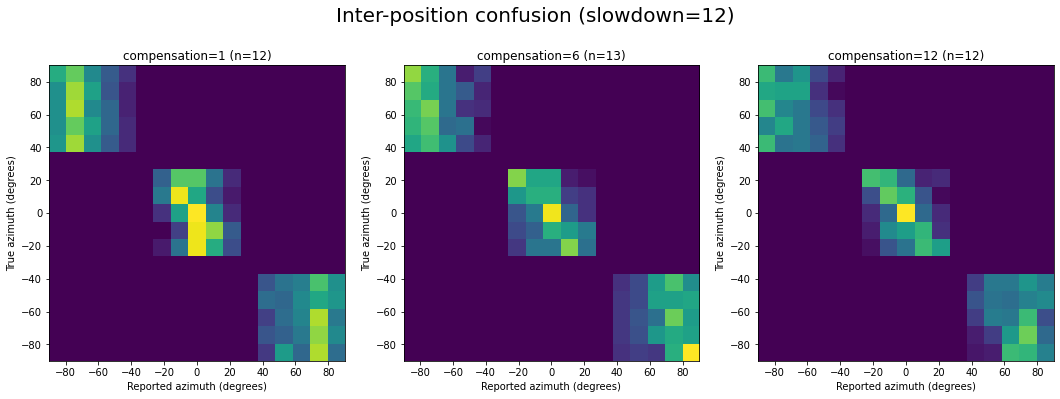

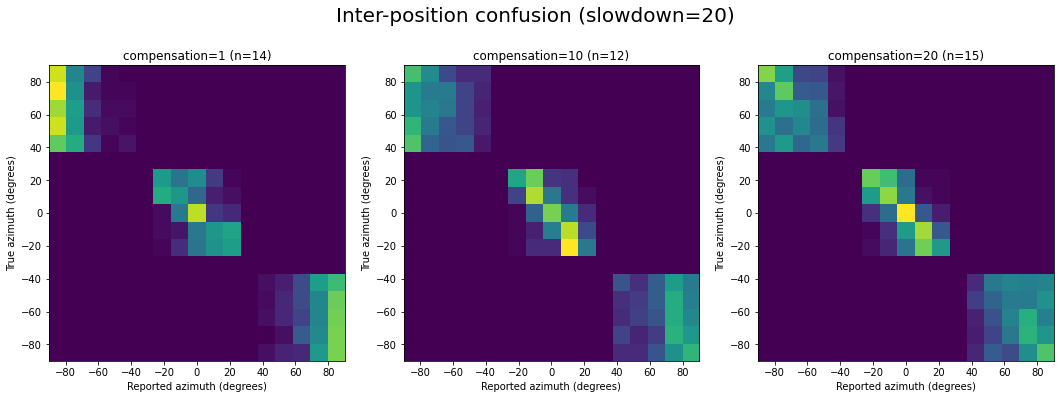

In [3]:

for slowdown in (12, 20):
    conditions = echo_study.subsect(slowdown=slowdown, compensation=[1, slowdown // 2, slowdown])
    plot_confusion(conditions, f"Inter-position confusion (slowdown={slowdown})", ["compensation"])

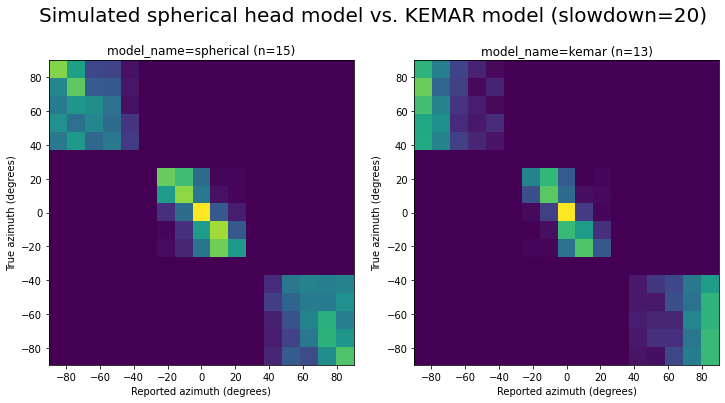

In [4]:
conditions = echo_study.spherical_vs_kemar(compensation=20, slowdown=20)
plot_confusion(conditions, "Simulated spherical head model vs. KEMAR model (slowdown=20)", ["model_name"])


/Users/ian/.local/share/virtualenvs/supernormal-echolocation-analysis-uYtYs_tf/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


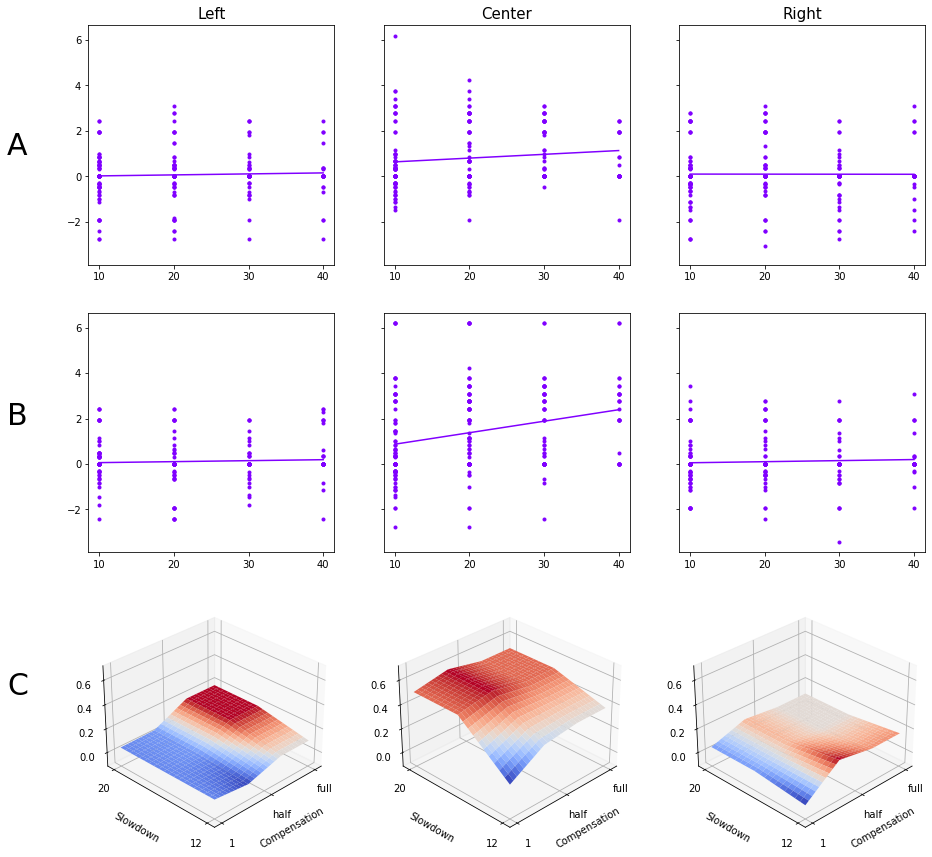

In [5]:

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy import interpolate

from loader import echo_study
from confusion import ConfusionMatrix
from sensitivity import get_individual_interstim_sensitivities_for_participants, lin_fit_sensitivities
from rmcorr import get_rmcorr_for_sensitivities_by_participant, load_rmcorr_results
from util import resolve_compensation_value



from rmcorr import load_rmcorr_results

sectors = ("left", "center", "right")
rmcorr_results = load_rmcorr_results()
colors = plt.cm.rainbow(np.linspace(0, 1, 3))
compensation_colors = {
    "1": colors[0],
    "half": colors[1],
    "full": colors[2], 
}

def _get_display_elements(slowdown, compensation_descriptor, **rest):
    color = compensation_colors[compensation_descriptor]
    compensation = resolve_compensation_value(slowdown, compensation_descriptor)
    marker = '.'
    linestyle = '-'
    label = f"S={slowdown} C={compensation}"
    return color, color, marker, linestyle, label


def _get_rmcorr_result_for_query(**query):
    return next((r for r in rmcorr_results if r.matches(query)), None)


def _get_rmcorr_slope_surface(sector):
    surface = np.zeros((2,3))
    for row, slowdown in enumerate((12, 20)):
        for col, compensation_descriptor in enumerate(("1", "half", "full")):
            rmcorr_result = _get_rmcorr_result_for_query(
                sector=sector,
                slowdown=slowdown,
                compensation_descriptor=compensation_descriptor,
            )
            surface[row, col] = rmcorr_result.slope
    f = interpolate.interp2d(x=np.arange(3), y=np.arange(2), z=surface)
    return f(np.arange(0,3,0.1), np.arange(0,2,0.1))
            
def plot_sensitivities(axis, conditions, get_display_elements, include_sector_title):
    for idx, sector in enumerate(sectors):
        for condition in conditions:
            rmcorr_result = _get_rmcorr_result_for_query(**condition.values, sector=sector)
            color, marker_color, marker, linestyle, label = get_display_elements(**condition.values)
            if rmcorr_result.slope_ci95_lower > 0:
                label = label + " *"
            if condition.count() == 0:
                continue
            s = get_individual_interstim_sensitivities_for_participants(condition.get(), sector)
            x, y = lin_fit_sensitivities(s)
            ax = axis[idx]
            if include_sector_title:
                ax.set_title(sector.capitalize(), fontsize=15)
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda t, pos: f"{int(10*t)}"))
            ax.set_xticks(range(1,6))
            ax.plot(x, y, color=color, label=f"{label}", linestyle=linestyle)
            ax.plot(*zip(*s), color=color, marker=marker, linestyle="None")
            break
            ax.set_xlabel("Stimulus separation (degrees)")
            ax.set_ylabel("d'", fontsize=20)
            ax.legend(loc="lower right")

fig, axes = plt.subplots(nrows=3, ncols=len(sectors), figsize=(15,15), sharey=True)

for idx, slowdown in enumerate((12, 20)):
    conditions = echo_study.subsect(slowdown=slowdown, compensation_descriptor=["1", "half", "full"])
    plot_sensitivities(axes[idx,:], conditions, _get_display_elements, idx == 0)

for idx, sector in enumerate(("left", "center", "right")):
    z = _get_rmcorr_slope_surface(sector)
    xrange = np.arange(z.shape[1])
    yrange = np.arange(z.shape[0])
    axes[2,idx].remove()
    ax = fig.add_subplot(3, 3, 7 + idx, projection='3d')
    x, y = np.meshgrid(xrange, yrange)
    ax.plot_surface(x, y, z, cmap=plt.cm.coolwarm)
    

    ax.view_init(30, -135)
    ax.set_xlabel("Compensation")
    ax.set_xticks([xrange[0], xrange[len(xrange)//2], xrange[-1]])
    ax.set_xticklabels(["1", "half", "full"])
    ax.set_ylabel("Slowdown")
    ax.set_yticks([yrange[0], yrange[-1]])
    ax.set_yticklabels(["12", "20"])
    ax.set_zlim(-0.1,0.7)

fig.text(0.05,0.76, "A", fontsize=30)
fig.text(0.05,0.51, "B", fontsize=30)
fig.text(0.05,0.26, "C", fontsize=30)

plt.show()

In [6]:
from confusion import ConfusionMatrix
from bootstrap import bootstrap_dprime_slope

def plot_bootstrapped_dprime_slope_distributions(conditions, title, label):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,5))
    fig.suptitle(title, size=20)
    bins = np.linspace(-0.4, 1, 100)
    for idx, sector in enumerate(("left", "center", "right")):
        slopes_data = {}
        for condition in conditions:
            hist_ax = axes[0, idx]
            box_ax = axes[1, idx]
            if condition.count() == 0:
                continue
            participants = condition.get()
            condition_label = condition.label(*label)
            confusion_matrices = [ConfusionMatrix.of_indices(p.get_responses(sector=sector)) for p in participants]
            (overall_slope, overall_intercept), slopes = bootstrap_dprime_slope(confusion_matrices, iterations=10000, use_rmcorr=True)
            slopes_data[condition_label] = slopes
            lower = np.percentile(slopes, 0.025)
            upper = np.percentile(slopes, 100 - 0.025)
            # print(f"{label}: 95% confidence interval = {np.round((lower, upper), 2)}")
            hist_ax.set_title(sector)
            hist_ax.hist(slopes, alpha=0.5, bins=bins, label=condition_label)
        # hist_ax.legend(loc='upper right')
        box_ax.boxplot(slopes_data.values())
        box_ax.set_xticklabels(list(slopes_data.keys()), fontdict=None, minor=False)
        box_ax.set_ylim(-0.5, 1.5)
    plt.show()

TypeError: cannot unpack non-iterable numpy.float64 object

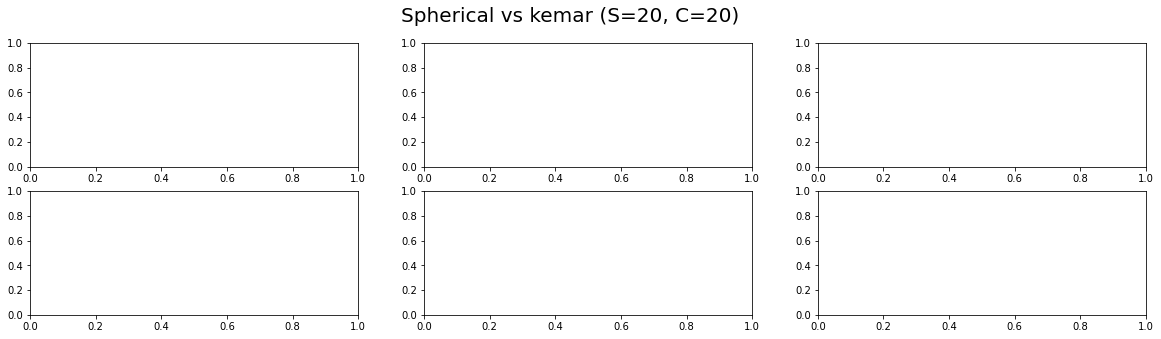

In [7]:
conditions = echo_study.spherical_vs_kemar(slowdown=20, compensation=20)
plot_bootstrapped_dprime_slope_distributions(conditions, "Spherical vs kemar (S=20, C=20)", label=["model_name"])

for slowdown in (12, 20):
    compensations = [resolve_compensation_value(slowdown, cv) for cv in ["1", "half", "full"]]
    conditions = echo_study.subsect(slowdown=slowdown, compensation=compensations)
    plot_bootstrapped_dprime_slope_distributions(conditions, f"Bootstrapped d' slope (S={slowdown})", label=["compensation"])

In [ ]:
from csv import DictWriter

from rmcorr import get_rmcorr_for_sensitivities_by_participant
from confusion import ConfusionMatrix
from sensitivity import get_interstim_sensitivities_for_confusion_matrix
from bootstrap import bootstrap_dprime_rmcorr_ci95
from loader import echo_study

filename = "rmcorr_analysis.csv"
columns = [
    "slowdown",
    "compensation_descriptor",
    "count",
    "sector",
    "slope",
    "rmcorr",
    "pval",
    "slope_ci95_lower",
    "slope_median",
    "slope_ci95_upper",
    "rmcorr_ci95_lower",
    "rmcorr_median",
    "rmcorr_ci95_upper"
]

conditions = echo_study.subsect(slowdown=[12,20], compensation_descriptor=["1", "half", "full"])
with open(filename, "w") as file:
    writer = DictWriter(file, columns)
    writer.writeheader()
    for condition in conditions:
        for sector in ("left", "center", "right"):
            participants = condition.get()
            confusion_matrices = [ConfusionMatrix.of_indices(p.get_responses(sector=sector)) for p in participants]
            sensitivities = [get_interstim_sensitivities_for_confusion_matrix(cm) for cm in confusion_matrices]
            slope, rmcorr, _, pval = get_rmcorr_for_sensitivities_by_participant(sensitivities)
            (
                (slope_ci95_lower, slope_median, slope_ci95_upper),
                (rmcorr_ci95_lower, rmcorr_median, rmcorr_ci95_upper)
            ) = bootstrap_dprime_rmcorr_ci95(confusion_matrices, 12, 10000)
            writer.writerow({
                "slowdown": condition.values["slowdown"],
                "compensation_descriptor": condition.values["compensation_descriptor"],
                "count": condition.count(),
                "sector": sector,
                "slope": slope,
                "rmcorr": rmcorr,
                "pval": pval,
                "slope_ci95_lower": slope_ci95_lower,
                "slope_median": slope_median,
                "slope_ci95_upper": slope_ci95_upper,
                "rmcorr_ci95_lower": rmcorr_ci95_lower,
                "rmcorr_median": rmcorr_median,
                "rmcorr_ci95_upper": rmcorr_ci95_upper,
            })


: 

In [8]:
import matplotlib.pyplot as plt

from confusion import ConfusionMatrix
from loader import echo_study
from sensitivity import get_interstim_sensitivities_for_confusion_matrix
from rmcorr import get_rmcorr_for_sensitivities_by_participant

q = echo_study.query_participants(slowdown=20, compensation=20)
ins = [
    get_interstim_sensitivities_for_confusion_matrix(
        ConfusionMatrix.of_indices(p.get_responses(sector="center"))
    ) 
    for p in q.get()
]
rm = get_rmcorr_for_sensitivities_by_participant(ins)
print(rm)

(0.5075881803792915, 0.38413241487700783, [0.28, 0.48], 1.7237511267361874e-11)


In [17]:
from models import Participant, Response

def score_response_laterality(response: Response):
    assert 0 in response.azimuth_choices
    should_score = response.true_azimuth in (-10, 10)
    if should_score:
        response_has_correct_side = (
            (response.true_azimuth < 0 and response.response_azimuth < 0) 
            or (response.true_azimuth > 0 and response.response_azimuth > 0)
        )
        return (1 if response_has_correct_side else 0, 1)
    return (0, 0)


def score_participant_on_laterality(participant: Participant):
    scores = []
    for block in participant.blocks:
        if block.center_azimuth == 0:
            for response in block.responses:
                score = score_response_laterality(response)
                scores.append(score)
    (numerators, denominators) = tuple(zip(*scores))
    return sum(numerators) / sum(denominators)

groups = echo_study.subsect(slowdown=[12,20], compensation_descriptor=["1", "half", "full"])
for group in groups:
    scores = [score_participant_on_laterality(p) for p in group.participants]
    print(
        "s={}, c={}".format(
            group.values["slowdown"],
            group.values["compensation_descriptor"]
        ),
        scores,
        "mean={}".format(sum(scores) / len(scores))
    )

s=12, c=1 [0.25, 0.3125, 0.875, 0.9375, 0.3125, 0.75, 0.5625, 0.5, 0.375, 0.375, 0.8125, 0.5] mean=0.546875
s=12, c=half [0.3125, 0.3125, 0.75, 0.4375, 0.6875, 0.25, 0.4375, 0.3125, 0.4375, 0.5, 0.6875, 1.0, 0.375] mean=0.5
s=12, c=full [0.625, 0.0625, 0.4375, 0.125, 0.5625, 0.4375, 0.25, 0.9375, 0.4375, 0.5, 0.9375, 0.3125] mean=0.46875
s=20, c=1 [1.0, 0.5625, 1.0, 1.0, 0.75, 0.8125, 1.0, 0.3125, 0.1875, 0.375, 0.0, 0.9375, 1.0, 0.9375] mean=0.7053571428571429
s=20, c=half [0.8125, 0.5, 0.875, 0.6875, 0.6875, 0.75, 0.4375, 0.875, 0.6875, 0.5, 0.75, 0.4375] mean=0.6666666666666666
s=20, c=full [0.375, 1.0, 0.9375, 0.0625, 0.9375, 0.9375, 1.0, 0.75, 0.75, 0.5625, 0.375, 0.75, 0.5, 0.9375, 0.375] mean=0.6833333333333333
